In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np

In [ ]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.0 MB/s 
     |████████████████████████████████| 81 kB 8.9 MB/s 
     |████████████████████████████████| 210 kB 53.3 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 146 kB 65.4 MB/s 
     |████████████████████████████████| 112 kB 53.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=5765010e006feb839172de633041d5dad41e3316471ccae09b926e222c1639b3
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Grid search

In [ ]:
def objective_gs(trial):
    n_layers = trial.suggest_int("n_layers", 1, 2)
    hidden_size = trial.suggest_categorical("hidden_size", [25, 50, 100])
    lr = trial.suggest_float("lr", 1e-3, 1)
    activation = trial.suggest_categorical("activation", ['tanh', 'relu'])
    max_iter = trial.suggest_categorical("max_iter", [10, 20])
    lr_type = trial.suggest_categorical("lr_type", ['constant', 'adaptive'])
    layers_params = []
    for i in range(n_layers):
        layers_params.append(hidden_size)
    layers_params = tuple(layers_params)
    clf = MLPClassifier(hidden_layer_sizes=layers_params, activation=activation, learning_rate_init=lr, learning_rate=lr_type, max_iter=max_iter)
    score = cross_val_score(clf, X_train, y_train, scoring='accuracy', n_jobs=-1, cv=5)
    accuracy = score.mean()
    return accuracy

In [ ]:
%%time
search_space = {'n_layers': [1, 2], 
                'hidden_size': [25, 50, 100],
                'lr': np.logspace(-3, 0, 4),
                'activation': ['tanh', 'relu'],
                'max_iter': [10, 20],
                'lr_type': ['constant', 'adaptive']}
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective_gs)

CPU times: user 1min 42s, sys: 36.2 s, total: 2min 18s
Wall time: 3h 24min 23s


In [ ]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 1440x1296 with 0 Axes>

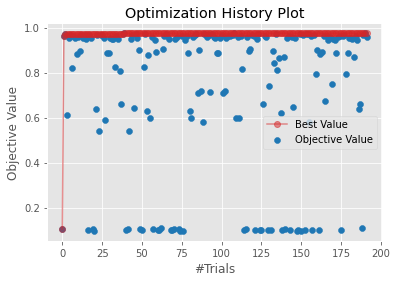

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig('MLP_GS_MNIST_HIST.pdf')

In [ ]:
print('MLP, grid search, best trial:')
print(study.best_trial.params)
print('MLP, grid search, best accuracy:')
print(study.best_value)
print('MLP, grid search, best trial number:')
print(study.best_trial.number)

MLP, grid search, best trial:
{'n_layers': 2, 'hidden_size': 100, 'lr': 0.001, 'activation': 'tanh', 'max_iter': 20, 'lr_type': 'adaptive'}
MLP, grid search, best accuracy:
0.9745000000000001
MLP, grid search, best trial number:
108


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 1440x1296 with 0 Axes>

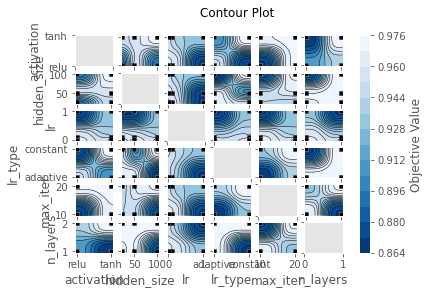

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_contour(study, params=['n_layers', "hidden_size", "lr", 'activation', 'max_iter', 'lr_type'])
plt.savefig('MLP_GS_MNIST_CP.pdf')

In [ ]:
def evaluate_accuracy(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    accuracy = (pred == y_test).mean()
    return accuracy

In [ ]:
hls = []
n_layers = study.best_trial.params['n_layers']
h_size = study.best_trial.params['hidden_size']
for i in range(n_layers):
    hls.append(h_size)
hls = tuple(hls)
mlp = MLPClassifier(hidden_layer_sizes=hls, learning_rate_init=study.best_trial.params['lr'], max_iter=study.best_trial.params['max_iter'], 
                    learning_rate=study.best_trial.params['lr_type'], activation=study.best_trial.params['activation'])
print('MLP, grid search, test accuracy:')
print(evaluate_accuracy(mlp, X_train, y_train, X_test, y_test))

MLP, grid search, test accuracy:
0.9758


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.



# Random Search

In [ ]:
def objective(trial):
    n_layers = trial.suggest_int("n_layers", 1, 2)
    hidden_size = trial.suggest_categorical("hidden_size", [25, 50, 100])
    lr = trial.suggest_float("lr", 1e-3, 1, log=True)
    activation = trial.suggest_categorical("activation", ['tanh', 'relu'])
    max_iter = trial.suggest_categorical("max_iter", [10, 20])
    lr_type = trial.suggest_categorical("lr_type", ['constant', 'adaptive'])
    layers_params = []
    for i in range(n_layers):
        layers_params.append(hidden_size)
    layers_params = tuple(layers_params)
    clf = MLPClassifier(hidden_layer_sizes=layers_params, activation=activation, learning_rate_init=lr, learning_rate=lr_type, max_iter=max_iter)
    score = cross_val_score(clf, X_train, y_train, scoring='accuracy', n_jobs=-1, cv=5)
    accuracy = score.mean()
    return accuracy

In [ ]:
%%time
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=192)

CPU times: user 2min 51s, sys: 51.6 s, total: 3min 42s
Wall time: 4h 59min 23s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  


<Figure size 1440x1296 with 0 Axes>

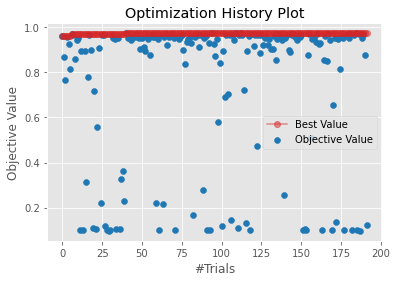

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig('MLP_RS_MNIST_HIST.pdf')

In [ ]:
print('MLP, random search, best trial:')
print(study.best_trial.params)
print('MLP, random search, best accuracy:')
print(study.best_value)
print('MLP, random search, best trial number:')
print(study.best_trial.number)

MLP, random search, best trial:
{'n_layers': 2, 'hidden_size': 100, 'lr': 0.0016974020365387657, 'activation': 'relu', 'max_iter': 10, 'lr_type': 'adaptive'}
MLP, random search, best accuracy:
0.9735666666666667
MLP, random search, best trial number:
94


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  


<Figure size 1440x1296 with 0 Axes>

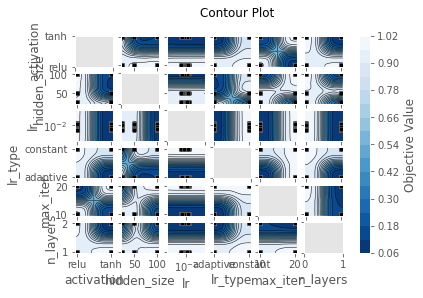

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_contour(study, params=['n_layers', "hidden_size", "lr", 'activation', 'max_iter', 'lr_type'])
plt.savefig('MLP_RS_MNIST_CP.pdf')

In [ ]:
hls = []
n_layers = study.best_trial.params['n_layers']
h_size = study.best_trial.params['hidden_size']
for i in range(n_layers):
    hls.append(h_size)
hls = tuple(hls)
mlp = MLPClassifier(hidden_layer_sizes=hls, learning_rate_init=study.best_trial.params['lr'], max_iter=study.best_trial.params['max_iter'], 
                    learning_rate=study.best_trial.params['lr_type'], activation=study.best_trial.params['activation'])
print('MLP, random search, test accuracy:')
print(evaluate_accuracy(mlp, X_train, y_train, X_test, y_test))

MLP, random search, test accuracy:
0.9742


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


# NSGA-II

In [ ]:
%%time
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.NSGAIISampler())
study.optimize(objective, n_trials=192)

CPU times: user 3min 8s, sys: 54.4 s, total: 4min 2s
Wall time: 5h 44min 22s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  


<Figure size 1440x1296 with 0 Axes>

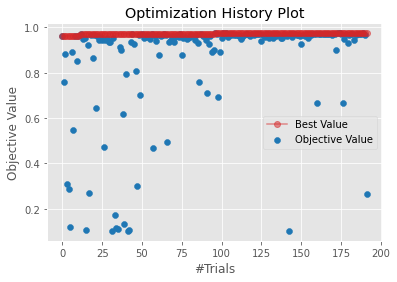

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig('MLP_NSGAII_MNIST_HIST.pdf')

In [ ]:
print('MLP, NSGA-II, best trial:')
print(study.best_trial.params)
print('MLP, NSGA-II, best accuracy:')
print(study.best_value)
print('MLP, NSGA-II, best trial number:')
print(study.best_trial.number)

MLP, NSGA-II, best trial:
{'n_layers': 2, 'hidden_size': 100, 'lr': 0.002341670826413672, 'activation': 'relu', 'max_iter': 20, 'lr_type': 'constant'}
MLP, NSGA-II, best accuracy:
0.9743999999999999
MLP, NSGA-II, best trial number:
101


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  


<Figure size 1440x1296 with 0 Axes>

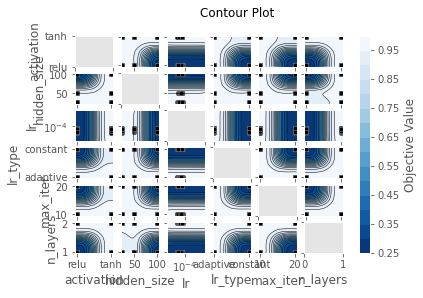

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_contour(study, params=['n_layers', "hidden_size", "lr", 'activation', 'max_iter', 'lr_type'])
plt.savefig('MLP_NSGAII_MNIST_CP.pdf')

In [ ]:
hls = []
n_layers = study.best_trial.params['n_layers']
h_size = study.best_trial.params['hidden_size']
for i in range(n_layers):
    hls.append(h_size)
hls = tuple(hls)
mlp = MLPClassifier(hidden_layer_sizes=hls, learning_rate_init=study.best_trial.params['lr'], max_iter=study.best_trial.params['max_iter'], 
                    learning_rate=study.best_trial.params['lr_type'], activation=study.best_trial.params['activation'])
print('MLP, NSGA-II, test accuracy:')
print(evaluate_accuracy(mlp, X_train, y_train, X_test, y_test))

MLP, NSGA-II, test accuracy:
0.9774


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


# TPE

In [ ]:
%%time
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=192)

CPU times: user 2min 13s, sys: 41.1 s, total: 2min 54s
Wall time: 5h 26min 28s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  


<Figure size 1440x1296 with 0 Axes>

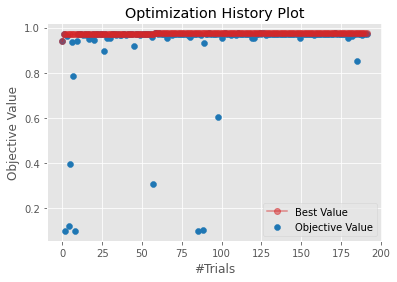

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig('MLP_TPE_MNIST_HIST.pdf')

In [ ]:
print('MLP, TPE, best trial:')
print(study.best_trial.params)
print('MLP, TPE, best accuracy:')
print(study.best_value)
print('MLP, TPE, best trial number:')
print(study.best_trial.number)

MLP, TPE, best trial:
{'n_layers': 1, 'hidden_size': 100, 'lr': 0.0020537496246346184, 'activation': 'relu', 'max_iter': 20, 'lr_type': 'constant'}
MLP, TPE, best accuracy:
0.97515
MLP, TPE, best trial number:
171


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  


<Figure size 1440x1296 with 0 Axes>

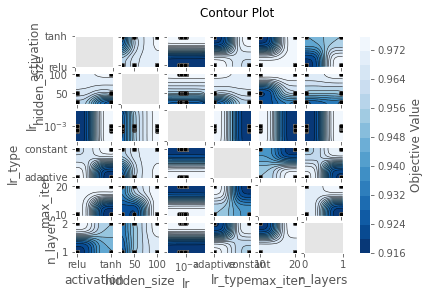

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_contour(study, params=['n_layers', "hidden_size", "lr", 'activation', 'max_iter', 'lr_type'])
plt.savefig('MLP_TPE_MNIST_CP.pdf')

In [ ]:
hls = []
n_layers = study.best_trial.params['n_layers']
h_size = study.best_trial.params['hidden_size']
for i in range(n_layers):
    hls.append(h_size)
hls = tuple(hls)
mlp = MLPClassifier(hidden_layer_sizes=hls, learning_rate_init=study.best_trial.params['lr'], max_iter=study.best_trial.params['max_iter'], 
                    learning_rate=study.best_trial.params['lr_type'], activation=study.best_trial.params['activation'])
print('MLP, TPE, test accuracy:')
print(evaluate_accuracy(mlp, X_train, y_train, X_test, y_test))

MLP, TPE, test accuracy:
0.9753


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


# CMA-ES

In [ ]:
%%time
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.CmaEsSampler())
study.optimize(objective, n_trials=192)

CPU times: user 3min 4s, sys: 53.5 s, total: 3min 57s
Wall time: 5h 39min 26s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  


<Figure size 1440x1296 with 0 Axes>

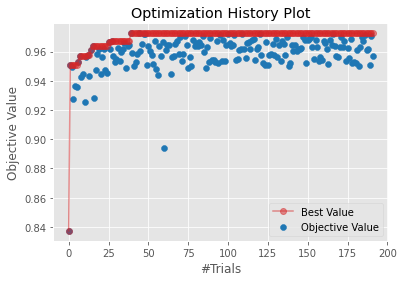

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig('MLP_CMAES_MNIST_HIST.pdf')

In [ ]:
print('MLP, CMA-ES, best trial:')
print(study.best_trial.params)
print('MLP, CMA-ES, best accuracy:')
print(study.best_value)
print('MLP, CMA-ES, best trial number:')
print(study.best_trial.number)

MLP, CMA-ES, best trial:
{'n_layers': 2, 'hidden_size': 100, 'lr': 0.0016617992930844493, 'activation': 'relu', 'max_iter': 10, 'lr_type': 'constant'}
MLP, CMA-ES, best accuracy:
0.9725666666666667
MLP, CMA-ES, best trial number:
39


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  


<Figure size 1440x1296 with 0 Axes>

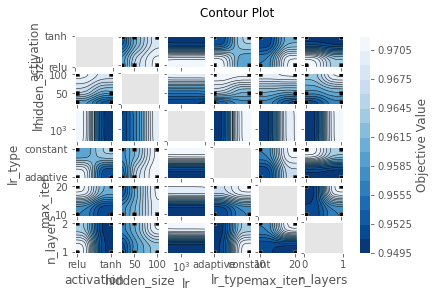

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_contour(study, params=['n_layers', "hidden_size", "lr", 'activation', 'max_iter', 'lr_type'])
plt.savefig('MLP_CMAES_MNIST_CP.pdf')

In [ ]:
hls = []
n_layers = study.best_trial.params['n_layers']
h_size = study.best_trial.params['hidden_size']
for i in range(n_layers):
    hls.append(h_size)
hls = tuple(hls)
mlp = MLPClassifier(hidden_layer_sizes=hls, learning_rate_init=study.best_trial.params['lr'], max_iter=study.best_trial.params['max_iter'], 
                    learning_rate=study.best_trial.params['lr_type'], activation=study.best_trial.params['activation'])
print('MLP, CMA-ES, test accuracy:')
print(evaluate_accuracy(mlp, X_train, y_train, X_test, y_test))

MLP, CMA-ES, test accuracy:
0.9756


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


# Bayesian optimization

In [ ]:
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 4.7 MB/s 


In [ ]:
from skopt import BayesSearchCV, gp_minimize
from skopt.plots import plot_objective, plot_convergence, plot_gaussian_process, plot_evaluations
from skopt.space import Real, Categorical, Integer

In [ ]:
space = [Categorical([1, 2], name='n_layers'),
         Categorical([25, 50, 100], name='hidden_size'),
         Categorical(['tanh', 'relu'], name='activation'),
         Categorical([10, 20], name='max_iter'),
         Categorical(['constant', 'adaptive'], name='lr_type'),
         Real(1e-3, 1, 'log-uniform', name='lr')
]

In [ ]:
def objective_bo(params):
    param_dict = {dim.name: val for dim, val in zip(space, params)}
    n_layers = param_dict["n_layers"]
    hidden_size = param_dict["hidden_size"]
    lr = param_dict["lr"]
    activation = param_dict["activation"]
    max_iter = param_dict["max_iter"]
    lr_type = param_dict["lr_type"]
    layers_params = []
    for i in range(n_layers):
        layers_params.append(hidden_size)
    layers_params = tuple(layers_params)
    clf = MLPClassifier(hidden_layer_sizes=layers_params, activation=activation, learning_rate_init=lr, learning_rate=lr_type, max_iter=max_iter)
    score = cross_val_score(clf, X_train, y_train, scoring='accuracy', n_jobs=-1, cv=5)
    accuracy = score.mean()
    return -accuracy

In [ ]:
%%time
res_gp = gp_minimize(objective_bo, space, n_calls=192)
print('MLP, BO, best params:')
print(f'n_layers: {res_gp.x[0]}, hidden_size: {res_gp.x[1]}, activation: {res_gp.x[2]}, max_iter: {res_gp.x[3]}, lr_type: {res_gp.x[4]}, lr: {res_gp.x[5]}')
print('MLP, BO, best accuracy:')
print(res_gp.fun)

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MLP, BO, best params:
n_layers: 2, hidden_size: 100, activation: tanh, max_iter: 20, lr_type: constant, lr: 0.001989438310025882
MLP, BO, best accuracy:
-0.97615
CPU times: user 12min 43s, sys: 4min 25s, total: 17min 9s
Wall time: 8h 42min 10s


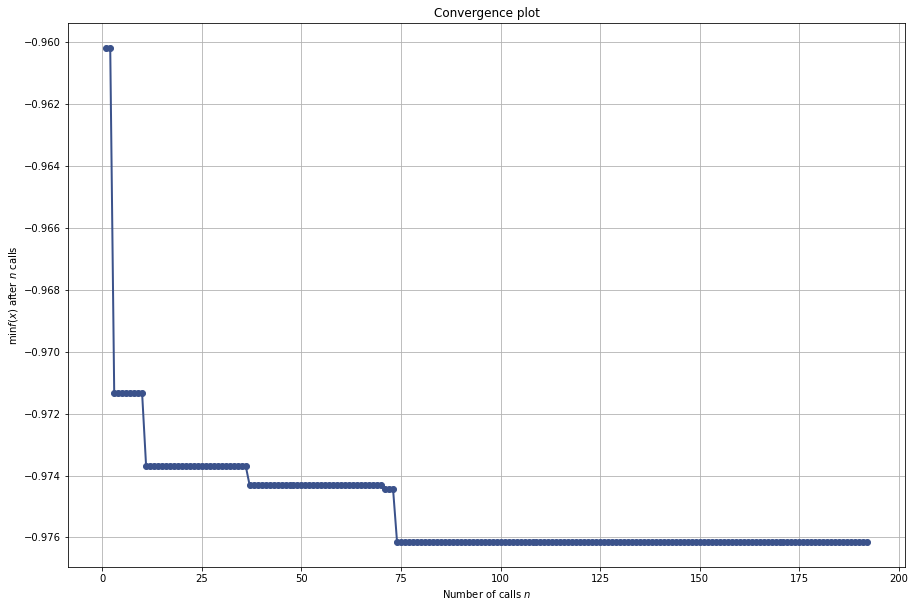

In [ ]:
plt.figure(figsize=(15, 10))
vis = plot_convergence(res_gp)
plt.savefig('MLP_BO_HIST.pdf')

<Figure size 1440x1080 with 0 Axes>

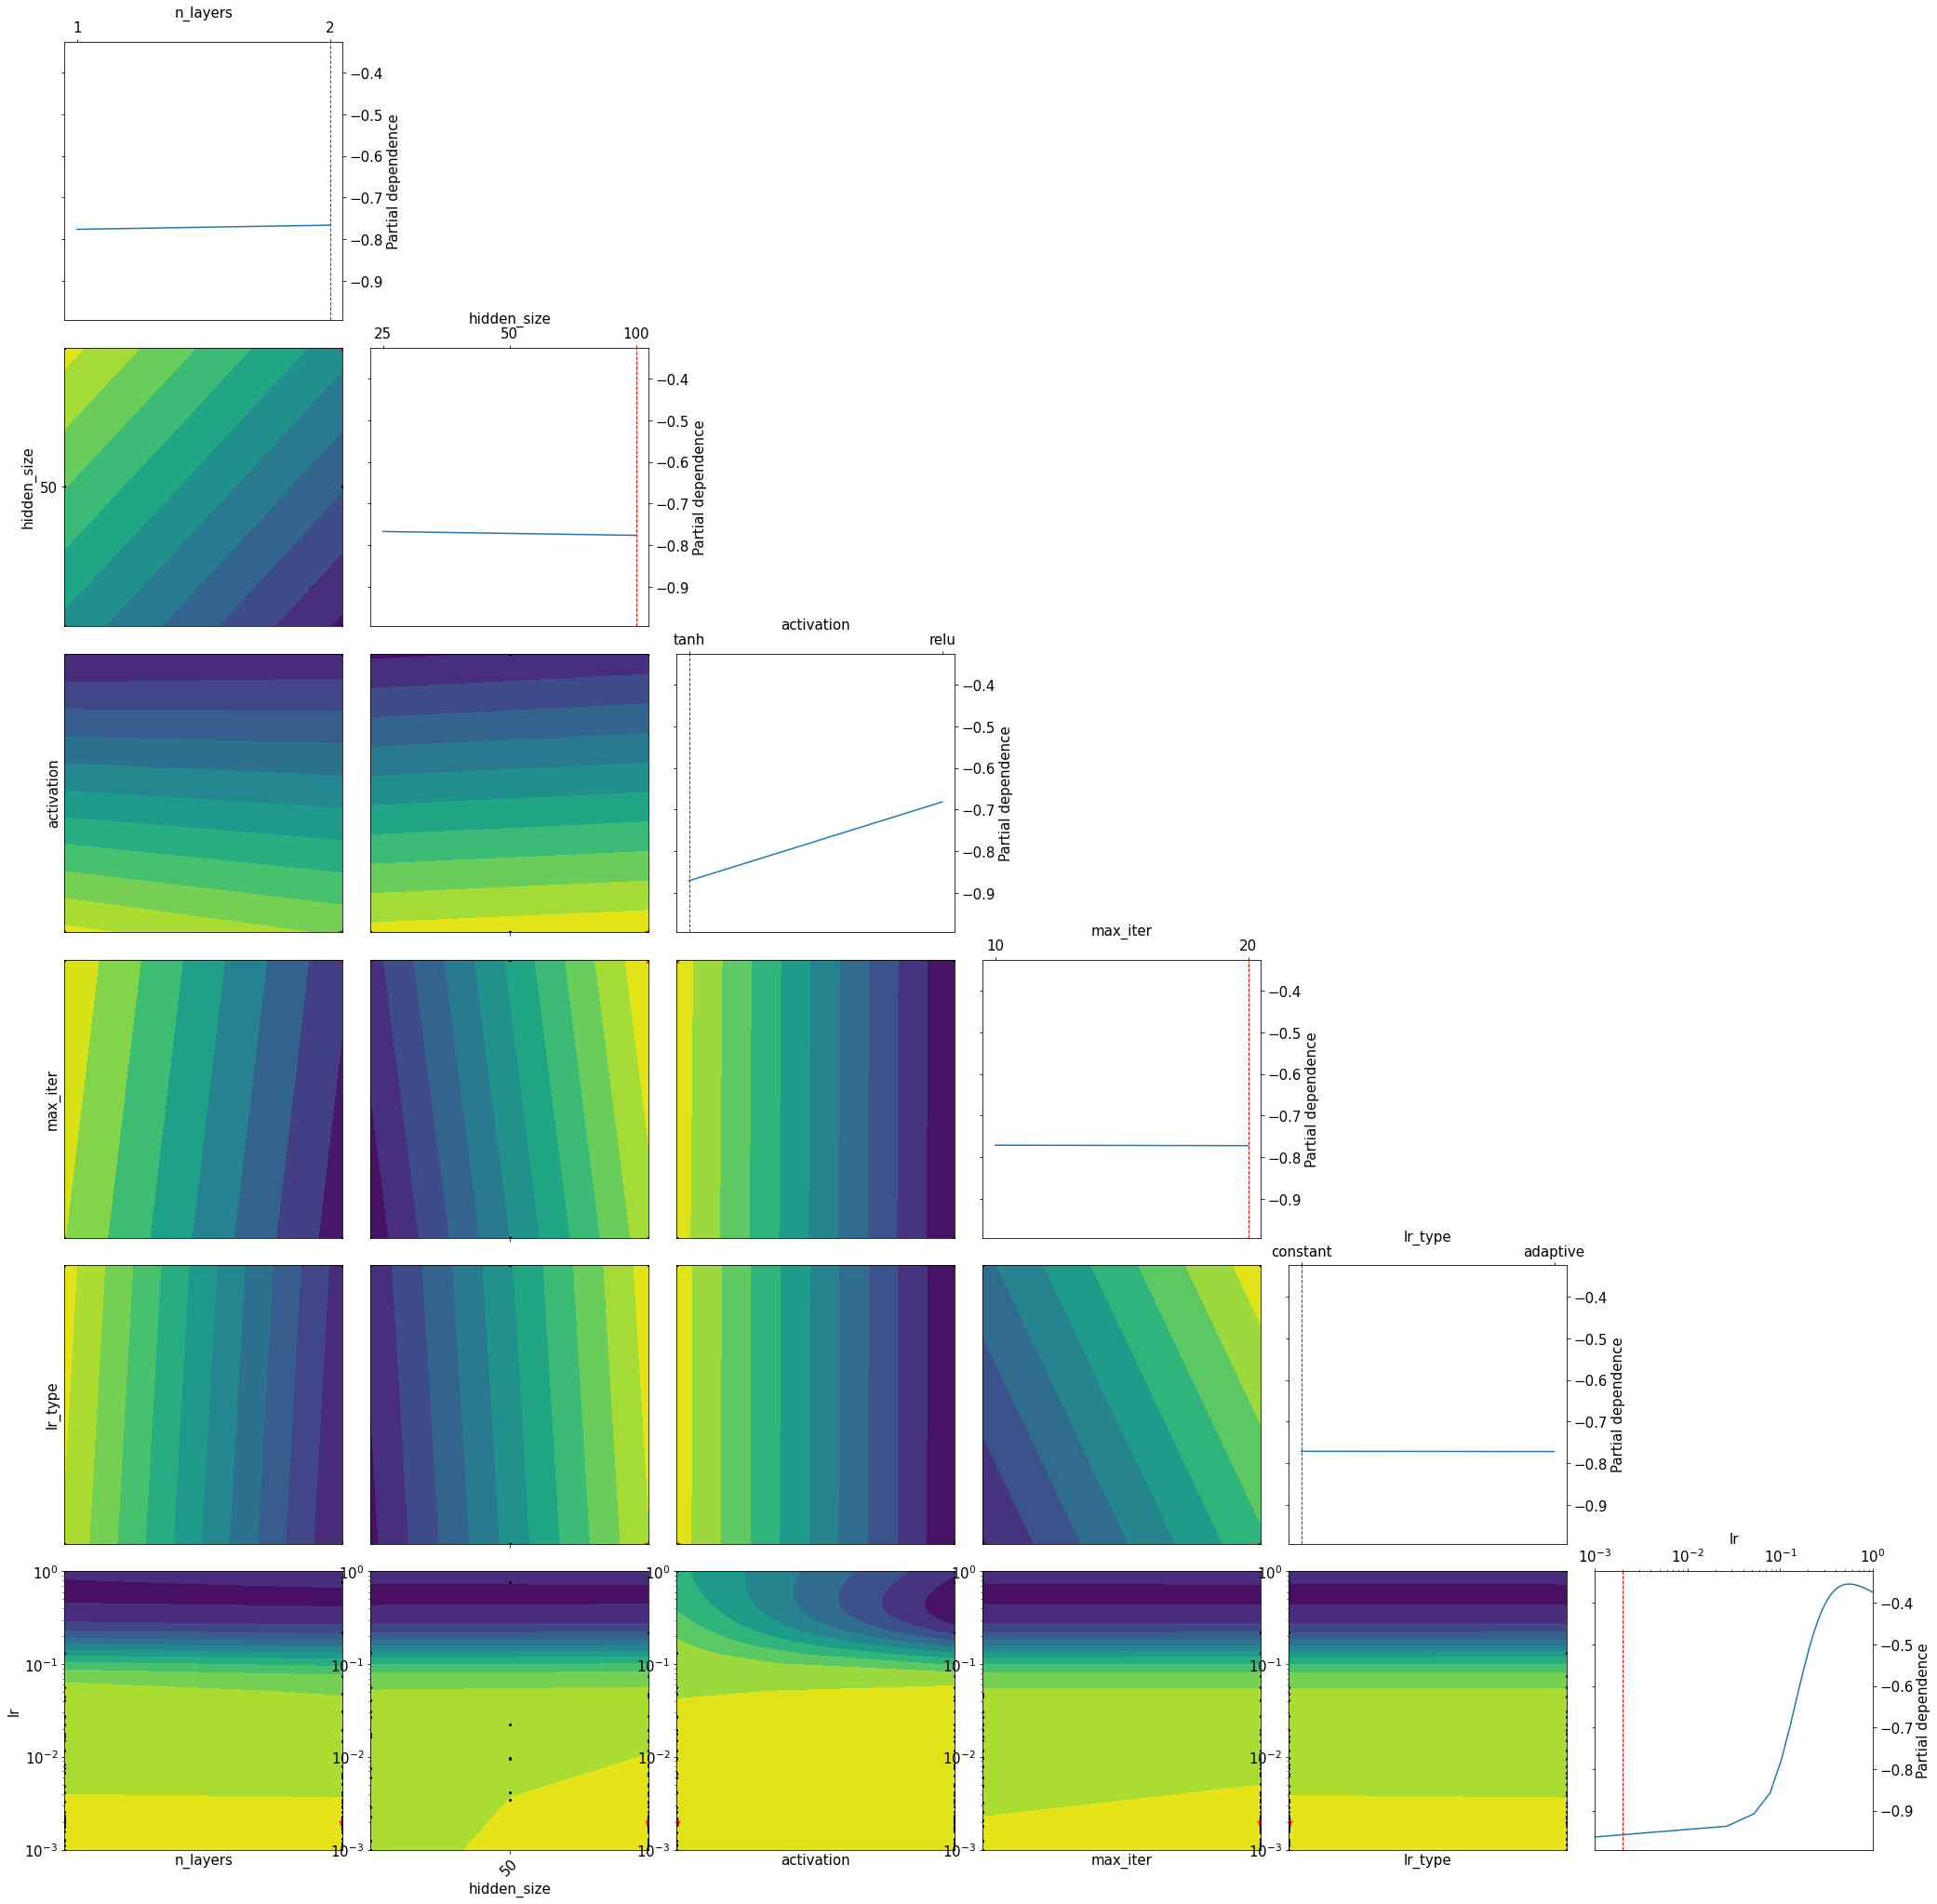

In [ ]:
plt.rc('font', size=15)
plt.figure(figsize=(20, 15))
plot_objective(res_gp, size=5)
plt.savefig(fname='MLP_CP_BO.pdf')

In [ ]:
hls = []
n_layers = res_gp.x[0]
h_size = res_gp.x[1]
for i in range(n_layers):
    hls.append(h_size)
hls = tuple(hls)
mlp = MLPClassifier(hidden_layer_sizes=hls, learning_rate_init=res_gp.x[5], max_iter=res_gp.x[3], 
                    learning_rate=res_gp.x[4], activation=res_gp.x[2])
print('MLP, CMA-ES, test accuracy:')
print(evaluate_accuracy(mlp, X_train, y_train, X_test, y_test))

MLP, CMA-ES, test accuracy:


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.9781
